
Synthetic Financial Datasets For Fraud Detection
Synthetic datasets generated by the PaySim mobile money simulator


https://www.kaggle.com/datasets/ealaxi/paysim1


step: time step or batch of transactions

type: transaction type (PAYMENT, TRANSFER, CASH_OUT, etc.)

amount: transaction amount

nameOrig / nameDest: originator and destination account IDs

oldbalanceOrg / newbalanceOrig: originator balances before/after transaction

oldbalanceDest / newbalanceDest: destination balances before/after transaction

isFraud: 0/1 label if transaction is fraud (you said you want to ignore this)

isFlaggedFraud: another fraud-related flag



In [38]:
import pandas as pd
import numpy as np
import kagglehub    
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor  
from sklearn.decomposition import PCA  

In [19]:
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\DRE113\.cache\kagglehub\datasets\ealaxi\paysim1\versions\2


In [20]:
df = pd.read_csv(path + "/PS_20174392719_1491204439457_log.csv")

In [21]:
print(df.head)

print(f"Rows before cleaning: {len(df)}")

<bound method NDFrame.head of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   
1  

In [22]:
df.info()
print("Overview of the dataset:")
print(df.dtypes)
print("Miissing values in each column:")
print(df.isnull().sum()) #so, no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Overview of the dataset:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object
Miissing values in each column:
step              0
type              0
amount            0
nameOrig          0
oldbalanc

In [23]:
# 1. Missing values check
print(df.isnull().sum())

# 2. Negative or zero values check
print("Negative amounts:", (df['amount'] < 0).sum())
print("Zero amounts:", (df['amount'] == 0).sum())
print("Negative old balances origin:", (df['oldbalanceOrg'] < 0).sum())
print("Negative new balances origin:", (df['newbalanceOrig'] < 0).sum())
print("Negative old balances dest:", (df['oldbalanceDest'] < 0).sum())
print("Negative new balances dest:", (df['newbalanceDest'] < 0).sum())

# 3. Duplicates check
print("Duplicate rows:", df.duplicated().sum())

# 4. Transaction types distribution
print(df['type'].value_counts())


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Negative amounts: 0
Zero amounts: 16
Negative old balances origin: 0
Negative new balances origin: 0
Negative old balances dest: 0
Negative new balances dest: 0
Duplicate rows: 0
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


In [24]:
transactions = df[df['amount'] > 0].copy()
print(f"Data shape after dropping zero amounts: {transactions.shape}")


Data shape after dropping zero amounts: (6362604, 11)


Feature engineering

In [25]:
#doing new dataframe to keep features from my actual tansactions 

features = pd.DataFrame(index=transactions.index)
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
features[numerical_features] = transactions[numerical_features]

features.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,9839.64,170136.0,160296.36,0.0,0.0
1,1864.28,21249.0,19384.72,0.0,0.0
2,181.00,181.0,0.00,0.0,0.0
3,181.00,181.0,0.00,21182.0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0


In [26]:
features["changeOrg"] = features['newbalanceOrig'] - features['oldbalanceOrg']
features["changeDest"] = features['newbalanceDest'] - features['oldbalanceDest']    

features["DifferenceOrg"] = abs(features["changeOrg"] - features['amount'])
features["DifferenceDest"] = abs(features["changeDest"] - features['amount'])

features.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changeOrg,changeDest,DifferenceOrg,DifferenceDest
0,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,19679.28,9839.64
1,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,3728.56,1864.28
2,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,362.00,181.00
3,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,362.00,21363.00
4,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,23336.28,11668.14


In [27]:
features["hour"] = transactions['step'] % 24

type_one_hot = pd.get_dummies(transactions['type'], prefix='type').astype(int)
features = pd.concat([features, type_one_hot], axis=1)  

features.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changeOrg,changeDest,DifferenceOrg,DifferenceDest,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,19679.28,9839.64,1,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,3728.56,1864.28,1,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,362.00,181.00,1,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,362.00,21363.00,1,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,23336.28,11668.14,1,0,0,0,1,0


In [28]:
assert all(features.index == transactions.index), "Index mismatch between features and transactions dataframes"


Looking at the data 

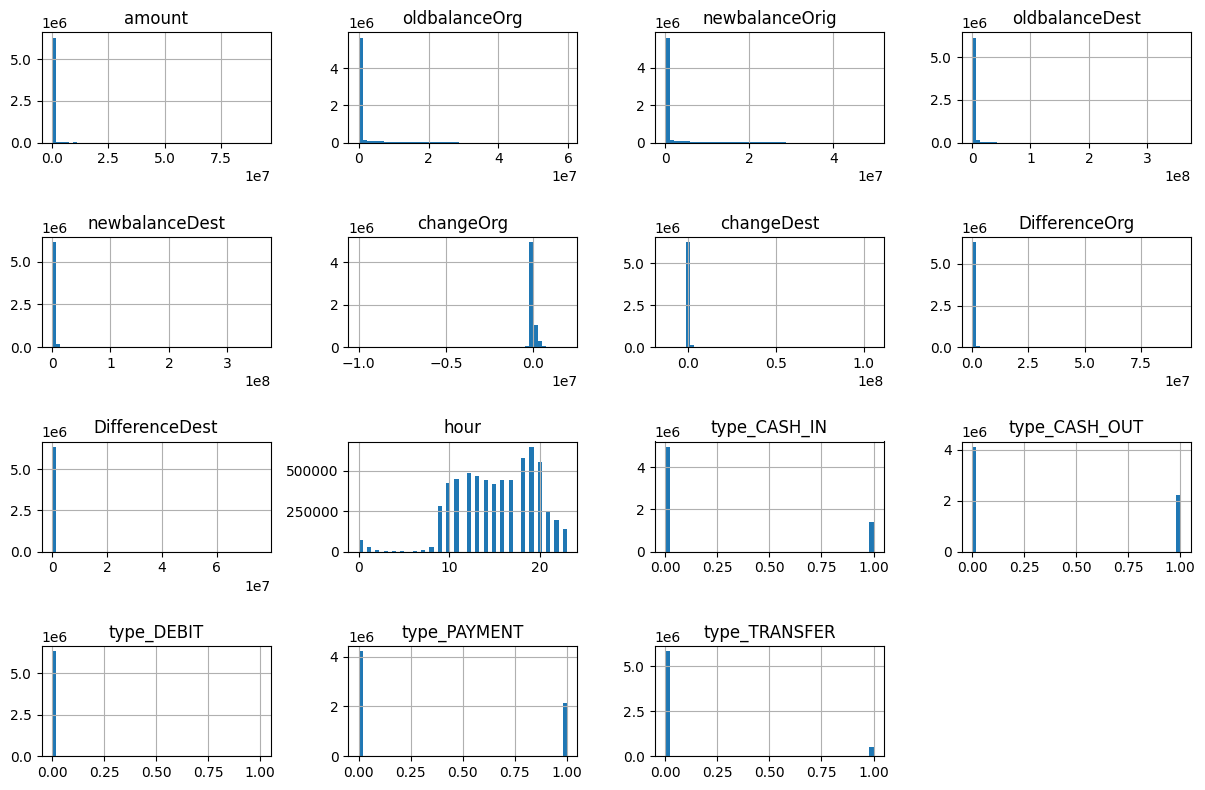

In [29]:
features.hist(figsize=(12, 8), bins=50)
plt.tight_layout()
plt.title("Distribution of Numerical Features") 
plt.show()

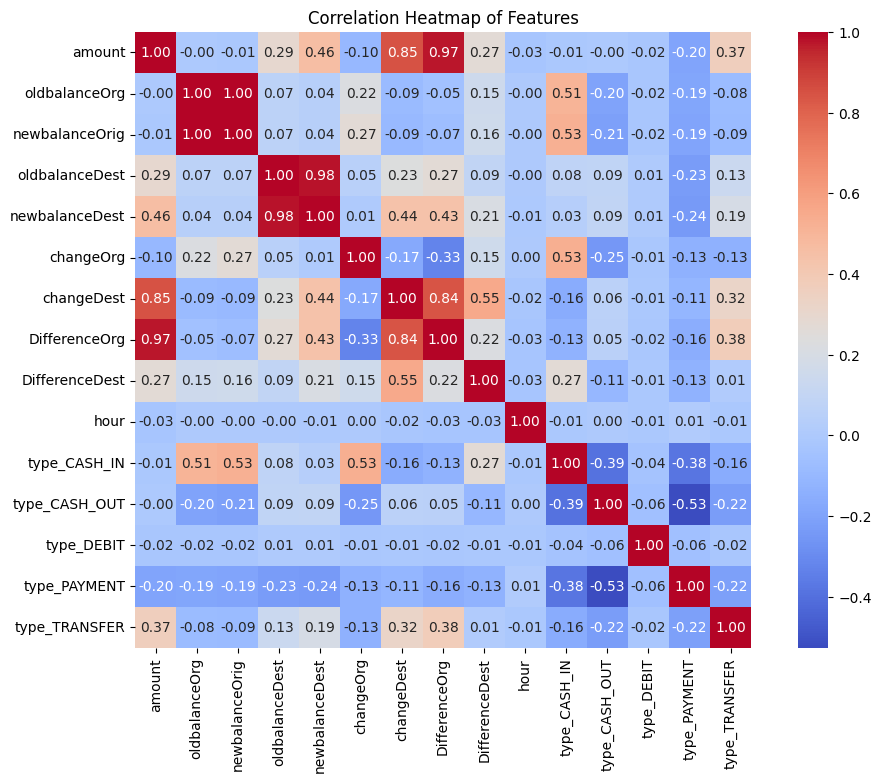

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(features.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Features")
plt.show()

anomaly detection

In [ ]:
scareler = StandardScaler()
fetures_scaled = scareler.fit_transform(features[numerical_features]) #scaling features so thez look nicer and kinda in the same range

In [36]:
isolation_forest = IsolationForest(contamination=0.01, random_state=42, n_estimators=100)
isolation_forest.fit(fetures_scaled)
features['iso_score'] = isolation_forest.decision_function(fetures_scaled)
features['iso_anomaly'] = isolation_forest.predict(fetures_scaled)

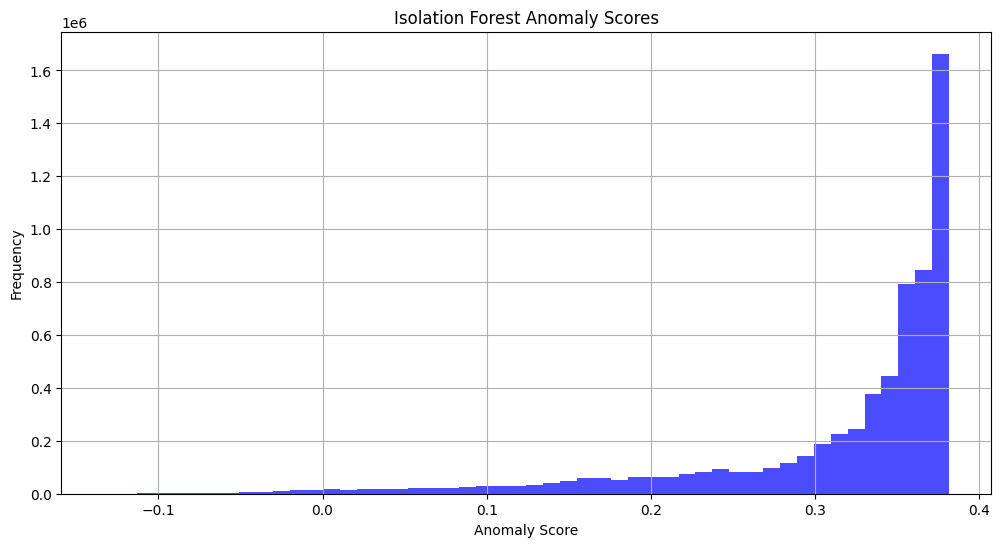

In [37]:
scores = features['iso_score']
plt.figure(figsize=(12, 6))
plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.title("Isolation Forest Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.grid()
plt.show()  

In [ ]:
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(fetures_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=features['iso_anomaly'], cmap='coolwarm', alpha=0.5)
plt.title("PCA of Features with Isolation Forest Anomalies")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Anomaly Status')
plt.grid()
plt.show()  